In [1]:
import subprocess
import os
import sys

import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

sys.path.insert(1, '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/')
# sys.path.insert(1, '/extra/stefan/utils/scrnaseq_utils/')
from scrnaseq_util_functions import *

In [2]:
data_path = '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'


h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name[:-3]] = os.path.join(path, name)
del h5_files['exampledataset']
del h5_files['NormanWeissman2019_raw']
del h5_files['PapalexiSatija2021_eccite_arrayed_protein']
del h5_files['PapalexiSatija2021_eccite_protein']
del h5_files['FrangiehIzar2021_protein']
print(len(h5_files))
list(h5_files.keys())

40


['PapalexiSatija2021_eccite_arrayed_RNA',
 'PapalexiSatija2021_eccite_RNA',
 'TianKampmann2021_CRISPRa',
 'TianKampmann2021_CRISPRi',
 'XieHon2017',
 'AissaBenevolenskaya2021',
 'McFarlandTshemiak2020_all_expts_combined',
 'GasperiniShendure2019_lowMOI',
 'GasperiniShendure2019_atscale',
 'GasperiniShendure2019_highMOI',
 'ZhaoSims2021',
 'DixitRegev2016',
 'DatlingerBock2017',
 'DatlingerBock2021',
 'FrangiehIzar2021_RNA',
 'WeinrebKlein2020',
 'ShifrutMarson2018',
 'ReplogleWeissman2022_K562_essential',
 'ReplogleWeissman2022_K562_gwps',
 'ReplogleWeissman2022_rpe1',
 'ChangYe2021',
 'gene_scores',
 'peak_bc',
 'ChromVar',
 'LSI_embedding',
 'markerpeak_target',
 'GehringPachter2019',
 'SchiebingerLander2019_GSE115943',
 'SchiebingerLander2019_GSE106340',
 'NormanWeissman2019_filtered',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen',
 'AdamsonWeissman2016_GSM2406677_10X005',
 'AdamsonWeissman2016_GSM2406681_10

In [3]:
modes=['simple_confusion', 'graph_entropy', 'pairwise_pca_distances', 'pseudobulk_distances', 'pseudobulk_correlations']

In [4]:
mode = 'simple_confusion'
key='PapalexiSatija2021_eccite_RNA'
df = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/{mode}_{key}_tables.csv', index_col=0)
precisions = np.diag(df) / np.sum(df, axis=1)

In [5]:
mode = 'pairwise_pca_distances'
df = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/{mode}_{key}_tables.csv', index_col=0)
df = 1/df
deltas = df.loc['control', :]
sigma = df.loc['control', 'control']
dps = deltas / sigma

In [6]:
tab = pd.concat([precisions, dps], axis=1)
tab.columns = ['precision', 'dps']

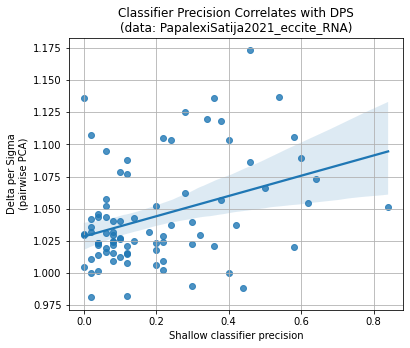

In [18]:
fig, ax = pl.subplots(figsize=[6,5])
sns.regplot(data=tab, x='precision', y='dps')
pl.xlabel('Shallow classifier precision')
pl.ylabel('Delta per Sigma\n(pairwise PCA)')
pl.grid()
pl.title('Classifier Precision Correlates with DPS\n(data: PapalexiSatija2021_eccite_RNA)')
pl.show()

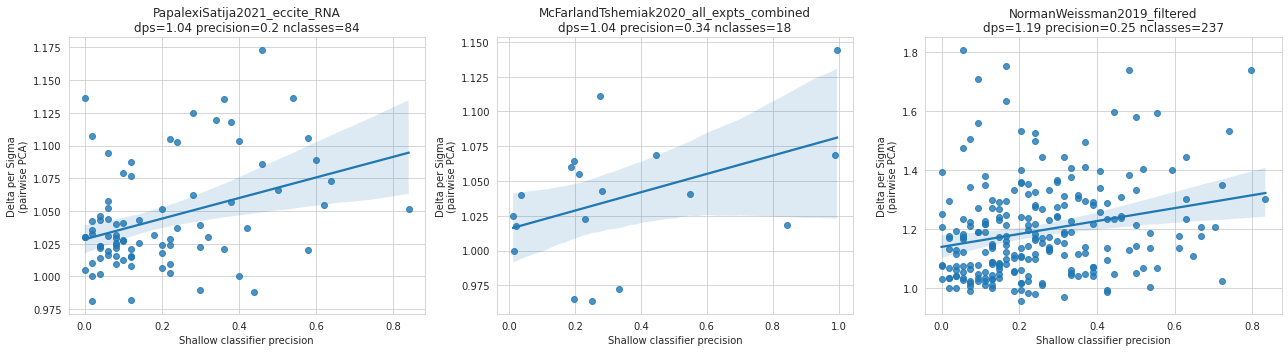

In [86]:
subset = ['PapalexiSatija2021_eccite_RNA', 'McFarlandTshemiak2020_all_expts_combined', 'NormanWeissman2019_filtered']
N = len(subset)
with sns.axes_style('whitegrid'): fig, axs = pl.subplots(1,N,figsize=[6*N, 5])
for key, ax in zip(subset, axs):
    mode = 'simple_confusion'
    df = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/{mode}_{key}_tables.csv', index_col=0)
    precisions = np.diag(df) / np.sum(df, axis=1)

    mode = 'pairwise_pca_distances'
    df = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/{mode}_{key}_tables.csv', index_col=0)
    df = 1/df
    deltas = df.loc['control', :]
    sigma = df.loc['control', 'control']
    dps = deltas / sigma

    tab = pd.concat([precisions, dps], axis=1)
    tab.columns = ['precision', 'dps']

    sns.regplot(data=tab, x='precision', y='dps', ax=ax, ci=95)
    ax.set_xlabel('Shallow classifier precision')
    ax.set_ylabel('Delta per Sigma\n(pairwise PCA)')
    ax.set_title(f'{key}\ndps={np.round(np.mean(dps),2)} precision={np.round(np.mean(precisions),2)} nclasses={len(dps)}')
pl.tight_layout()
pl.show()